Rafał Nowak
# Numerical Optimization
## Problem set 2 (15 points)

**Submission deadline**: Wednesday, 1.12.2021

* All submissions should contain single file.<br/>This can be single Jupyter notebook file (with extension `ipynb`) or ZIP archive in case the are some additional files needed.
* It is recommended to write the reports using LaTeX. 
* One can report the answers, comments and results in PDF or notebook file.
* All the source code should be written in Python or Julia.

# Problem 2.1 (5 pts)

Assume have a~set of $N$ noisy measurements $(x_i, \tilde y_i)\in\mathbb R^2$ onto which we would like to to fit a line $y=ax+b$. This task can be expressed by the following optimization problem in $L_2$ norm:
$$ \min_{a,b} \sum_{i=1}^N \left(a x_i + b - \tilde y_i\right)^2 = \min_{a,b} \left\| J \begin{pmatrix}a\\b\end{pmatrix} - \tilde y \right\|_2^2,$$
where $\|\cdot\|_2$ means the $L_2$ norm.

One can check that the optimal solution can be obtained by solving the linear system
$$ J^T J \begin{pmatrix}a\\b\end{pmatrix} = J^T \tilde y. $$

* (1 pt) Generate the problem data. Take $N=30, 50, 100$ points in the interval $[0,5]$ and generate the true outputs $y_i = a x_i + b$ for some $a,b\in\mathbb R$; for example take $a=3, b=4$. Add Gaussian noise $~N(0,1)$ to get the noisy measurements $\tilde y_i$ and plot the results.
* (2 pt) Compute the matrix $J$ and solve the problem using your implementation of Gaussian elimination (see problem 1.1). Plot the obtained line in the same graph as the measurements. 
* (1 pt) Next use any implementation (like `np.linalg.solve`) instead of your Gaussian elimination. Compare the resulting cost function values.
* (1 pt) Finally, add some outliers to the data and plot the results (single graph with measurements and solution line).

In [1]:
!python -V

Python 3.9.7


In [2]:
from typing import *
import numpy as np
import time
from PIL import Image
from numpy.linalg import inv
from numba import jit
import scipy
from scipy.linalg import block_diag
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import plotly.graph_objects as go

%config IPCompleter.greedy=True

## 2.1.1 Visualize the problem

In [3]:
N_list = [30, 50, 100]
a, b = 3, 4

X = [np.linspace(0, 5, n) for n in N_list]
Y = [a * x + b for x in X]
Y_hat = [y + np.random.normal(0, 1, y.shape) for y in Y]

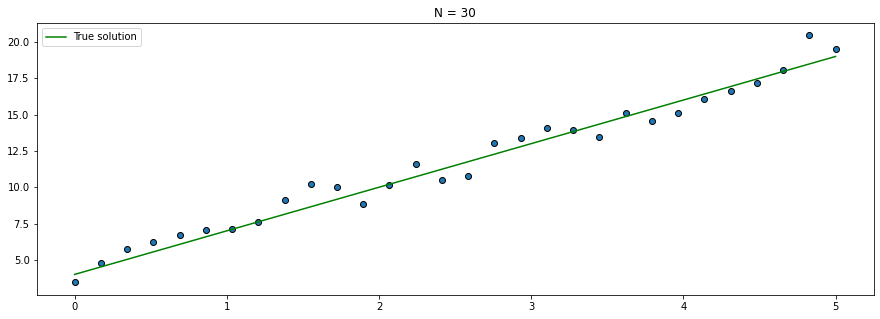

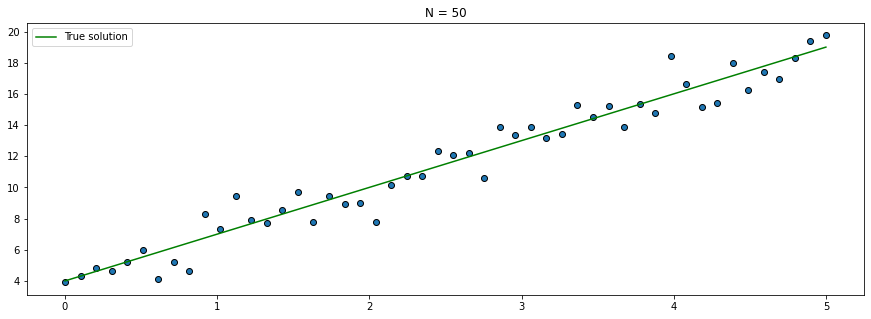

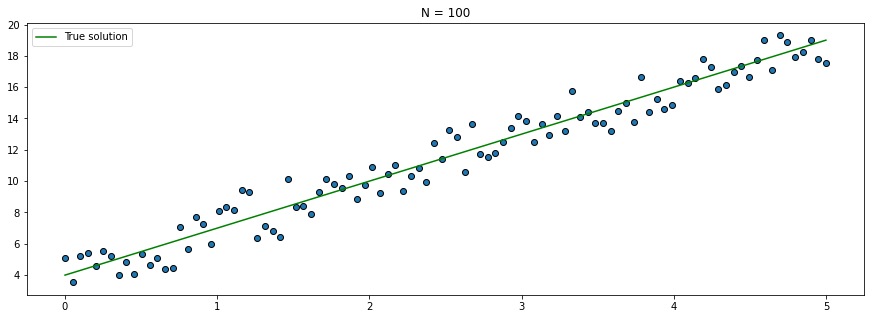

In [4]:
for i in range(3):
    plt.figure(figsize=(15, 5))
    plt.scatter(X[i], Y_hat[i], edgecolors='black')
    plt.plot(X[i], Y[i], color='green', label='True solution')
    plt.title(f'N = {N_list[i]}')
    plt.legend()
    plt.show()

## 2.1.2 solve using Gaussian elimination

In [5]:
@jit(nopython=True)
def gauss(M: np.ndarray) -> np.ndarray:
    n = m = M.shape[0]
    for j in range(m):
        for i in range(n):
            if i == j:
                continue
            M[i] -= (M[i][j] / (M[j][j] + 1e-18)) * M[j]

    for i in range(n):
        M[i] /= (M[i][i] + 1e-18)

    return M[:, -1]

In [6]:
J_list = [np.c_[X[i], np.ones(N_list[i])] for i in range(3)]

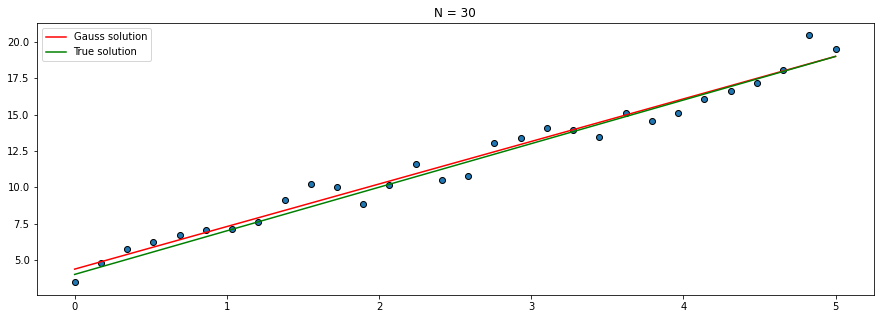

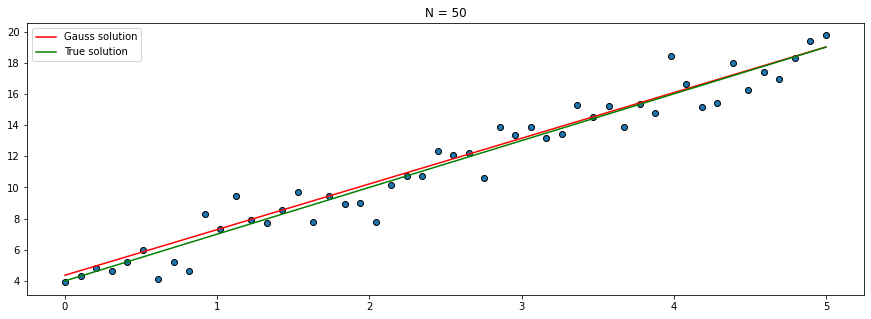

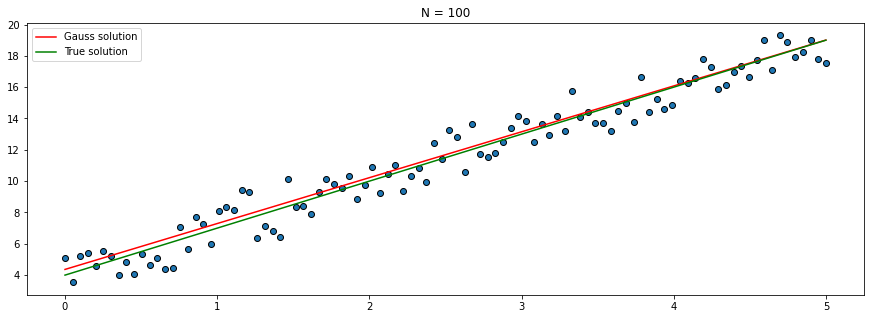

In [7]:
for i in range(3):
    a, b = gauss(M=np.c_[J_list[0].T @ J_list[0], J_list[0].T @ Y_hat[0]].astype(np.float64))
    plt.figure(figsize=(15, 5))
    plt.scatter(X[i], Y_hat[i], edgecolors='black')
    plt.plot(X[i], a * X[i] + b, color='red', label='Gauss solution')
    plt.plot(X[i], Y[i], color='green', label='True solution')
    plt.title(f'N = {N_list[i]}')
    plt.legend()
    plt.show()

## 2.1.3 Solve using np.linalg.solve

1 / 3 | N = 30 | True cost = 17.23 | My gauss cost = 15.86 | Numpy cost = 15.86
My gauss: a = 2.928775 b = 4.364170 | Numpy: a = 2.928775 b = 4.364170


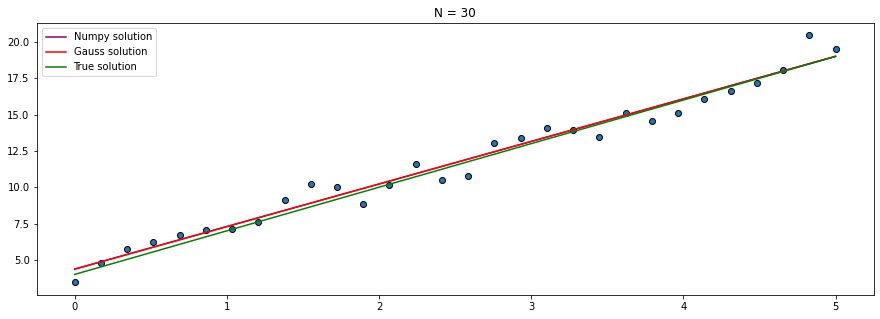

2 / 3 | N = 50 | True cost = 48.90 | My gauss cost = 52.52 | Numpy cost = 52.52
My gauss: a = 2.928775 b = 4.364170 | Numpy: a = 2.928775 b = 4.364170


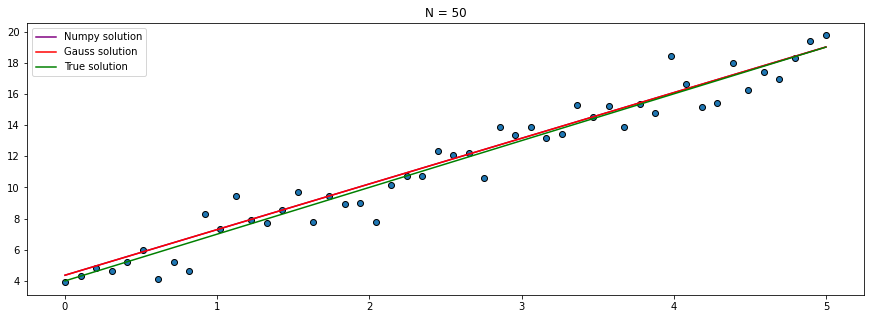

3 / 3 | N = 100 | True cost = 88.44 | My gauss cost = 93.99 | Numpy cost = 93.99
My gauss: a = 2.928775 b = 4.364170 | Numpy: a = 2.928775 b = 4.364170


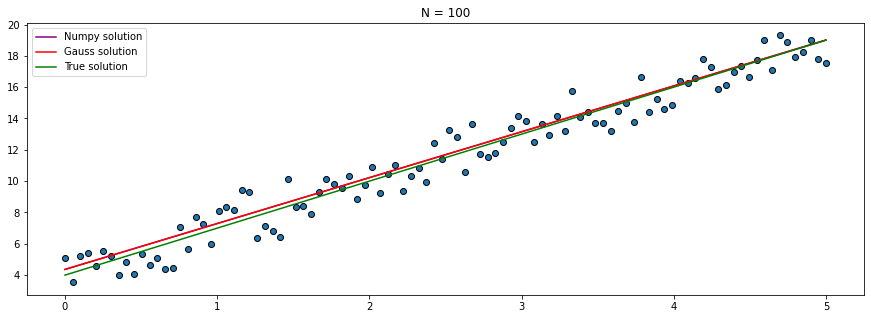

In [8]:
for i in range(3):
    a, b = gauss(M=np.c_[J_list[0].T @ J_list[0], J_list[0].T @ Y_hat[0]].astype(np.float64))
    a_np, b_np = np.linalg.solve(J_list[0].T @ J_list[0], J_list[0].T @ Y_hat[0])
    
    true_cost =  ((Y_hat[i] - Y[i]) ** 2).sum()
    gauss_cost = ((a * X[i] + b - Y_hat[i]) ** 2).sum()
    numpy_cost = ((a_np * X[i] + b_np - Y_hat[i]) ** 2).sum()
    
    print(f'{i + 1} / 3 | N = {N_list[i]} | True cost = {true_cost :.2f} | My gauss cost = {gauss_cost :.2f} | Numpy cost = {numpy_cost :.2f}')
    print(f'My gauss: a = {a :.6f} b = {b :.6f} | Numpy: a = {a_np :.6f} b = {b_np :.6f}')
    
    plt.figure(figsize=(15, 5))
    plt.scatter(X[i], Y_hat[i], edgecolors='black')
    plt.plot(X[i], a_np * X[i] + b_np, color='purple', label='Numpy solution')
    plt.plot(X[i], a * X[i] + b, color='red', label='Gauss solution')
    plt.plot(X[i], Y[i], color='green', label='True solution')
    plt.title(f'N = {N_list[i]}')
    plt.legend()
    plt.show()

## 2.1.4 Add outliers

In [9]:
# select some indices at random and make them outliers

indices = [np.random.randint(0, N_list[i], int(np.sqrt(N_list[i]))) for i in range(3)]

for i in range(3):
    # move each selected point by +/- k * std, where k can be 2, 3 or 4
    std = Y_hat[i].std()
    
    if np.random.randn() < 0.5:
        Y_hat[i][indices[i]] += np.random.randint(2, 5) * std
    else:
        Y_hat[i][indices[i]] -= np.random.randint(2, 5) * std

1 / 3 | N = 30 | True cost = 383.88 | My gauss cost = 290.35 | Numpy cost = 290.35
My gauss: a = 3.397573 b = 4.669079 | Numpy: a = 3.397573 b = 4.669079


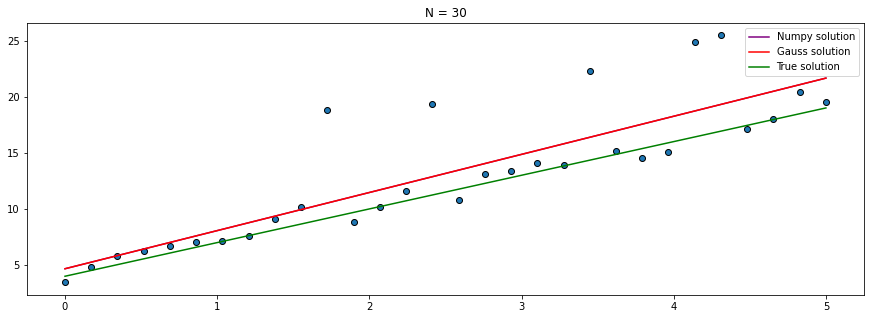

2 / 3 | N = 50 | True cost = 1137.67 | My gauss cost = 1588.96 | Numpy cost = 1588.96
My gauss: a = 3.397573 b = 4.669079 | Numpy: a = 3.397573 b = 4.669079


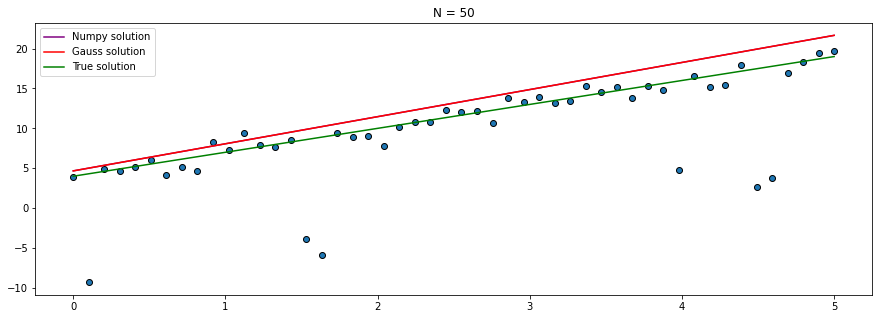

3 / 3 | N = 100 | True cost = 1717.84 | My gauss cost = 1601.80 | Numpy cost = 1601.80
My gauss: a = 3.397573 b = 4.669079 | Numpy: a = 3.397573 b = 4.669079


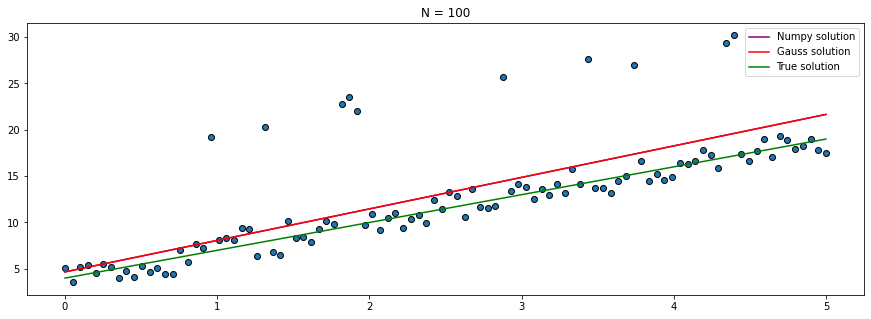

In [10]:
for i in range(3):
    a, b = gauss(M=np.c_[J_list[0].T @ J_list[0], J_list[0].T @ Y_hat[0]].astype(np.float64))
    a_np, b_np = np.linalg.solve(J_list[0].T @ J_list[0], J_list[0].T @ Y_hat[0])
    
    true_cost =  ((Y_hat[i] - Y[i]) ** 2).sum()
    gauss_cost = ((a * X[i] + b - Y_hat[i]) ** 2).sum()
    numpy_cost = ((a_np * X[i] + b_np - Y_hat[i]) ** 2).sum()
    
    print(f'{i + 1} / 3 | N = {N_list[i]} | True cost = {true_cost :.2f} | My gauss cost = {gauss_cost :.2f} | Numpy cost = {numpy_cost :.2f}')
    print(f'My gauss: a = {a :.6f} b = {b :.6f} | Numpy: a = {a_np :.6f} b = {b_np :.6f}')
    
    plt.figure(figsize=(15, 5))
    plt.scatter(X[i], Y_hat[i], edgecolors='black')
    plt.plot(X[i], a_np * X[i] + b_np, color='purple', label='Numpy solution')
    plt.plot(X[i], a * X[i] + b, color='red', label='Gauss solution')
    plt.plot(X[i], Y[i], color='green', label='True solution')
    plt.title(f'N = {N_list[i]}')
    plt.legend()
    plt.show()

As one can see outliers don't change much here.

---

# Problem 2.3 (3 pts)

In this problem you are going to fit a line to the set of measurements, but this time with $L_1$ norm, i.e.
$$ \min_{a,b} \sum_{i=1}^{N} |a x_i + b - y_i|. $$
which is not diffentiable. Use some slack variables $s_1, s_2, \ldots, s_N$ and reformulate the problem
into the form
$$
\begin{alignat}{2}
                   & \min_{a,b,s} \sum_i s_i,\\
\text{s.t.} \qquad & -s_i \leq ax_i+b-y_i \leq s_i, \qquad & i=1,2,\ldots, N,\\
                   & s_i \geq 0,                           & i=1,2,\ldots, N.
\end{alignat}
$$

* Solve the problem using the measurements generated in the previous exercise (both with and without outliers)
* You can use any LP solver (recommended Gurobi).

Remark. You can get **extra 2 points** if you use your implementation of Simplex method and obtain similar results. Test your method not only with $a=3, b=4$.

### Rewriting the problem into standard form

In [11]:
constrains1_list = [
    np.c_[
        X[i], X[i] * -1, 
        np.ones(N_list[i]), np.ones(N_list[i]) * -1, 
        np.eye(N_list[i]) * -1, np.eye(N_list[i]), np.zeros((N_list[i], N_list[i]))
    ] 
    for i in range(3)
]
constrains2_list = [
    np.c_[
        X[i], X[i] * -1, 
        np.ones(N_list[i]), np.ones(N_list[i]) * -1, 
        np.eye(N_list[i]), np.zeros((N_list[i], N_list[i])), np.eye(N_list[i]) * -1
    ]
    for i in range(3)
]

M_final_list = [np.r_[constrains1_list[i], constrains2_list[i]] for i in range(3)]

b_list = [np.r_[Y_hat[i], Y_hat[i]] for i in range(3)]

c_list = [
    np.r_[np.zeros(4), np.ones(N_list[i]), np.zeros(2 * N_list[i])] 
    for i in range(3)
]

In [12]:
%%time
opt_list = [
    linprog(
        c=c_list[i], A_eq=M_final_list[i], b_eq=b_list[i], bounds=(0, np.inf),
        method="simplex"
    )
    for i in range(3)
]

CPU times: user 734 ms, sys: 483 ms, total: 1.22 s
Wall time: 212 ms


1 / 3 | N = 30 | True cost = 58.53 | Scipy solver cost = 54.92


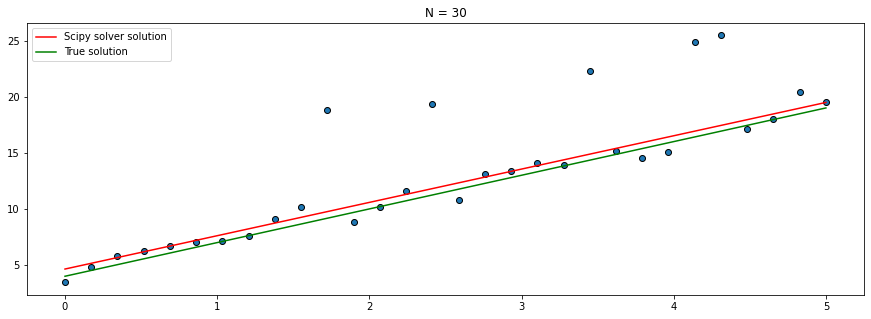

2 / 3 | N = 50 | True cost = 112.59 | Scipy solver cost = 54.92


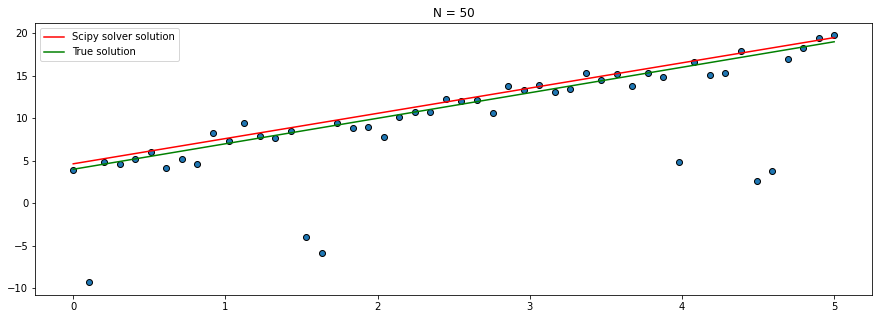

3 / 3 | N = 100 | True cost = 201.61 | Scipy solver cost = 54.92


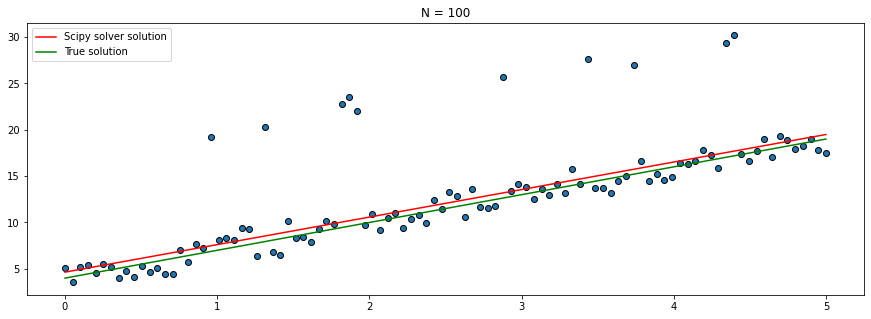

In [13]:
for i in range(3):
    a1, a2, b1, b2 = opt_list[0]['x'][:4]
    
    a = a1 - a2
    b = b1 - b2
    
    cost_from_opt = opt_list[0]['fun']
    
    true_cost =  np.abs((Y_hat[i] - Y[i])).sum()
    
    print(f'{i + 1} / 3 | N = {N_list[i]} | True cost = {true_cost :.2f} | Scipy solver cost = {cost_from_opt :.2f}')
    
    plt.figure(figsize=(15, 5))
    plt.scatter(X[i], Y_hat[i], edgecolors='black')
    plt.plot(X[i], a * X[i] + b, color='red', label='Scipy solver solution')
    plt.plot(X[i], Y[i], color='green', label='True solution')
    plt.title(f'N = {N_list[i]}')
    plt.legend()
    plt.show()

### My simplex

In [14]:
def simplex_method(A, b, I, c, max_iters: int=10000) -> Optional[Tuple[float, np.ndarray]]:
    """
    Returns Tuple[v, x], where v is the optimal value
        and x is the corresponding vector
    """
    A = np.array(A, dtype=np.float64)
    b = np.array(b, dtype=np.float64)
    c = np.array(c, dtype=np.float64)
    I = np.array(I, dtype=np.int32)
    
    Ab = np.c_[A, b]
    
    for i in range(max_iters):
        B = Ab[:, I]

        B_inv = inv(B)  # inverse basis with basic variables
        Ab = B_inv @ Ab

        chosen = np.zeros(len(c), dtype=bool)
        chosen[I] = True

        cb = c[chosen]
        cn = c[~chosen]

        r = np.zeros(len(c))
        r[~chosen] = (cn - (Ab[:, np.r_[~chosen, False]].T @ cb[:, np.newaxis]).T).ravel()
        
        if min(r) >= 0:
            x_ans = np.zeros(len(c), dtype=np.float64)
            x_ans[chosen] = Ab[:, -1]
            f_val: float = (c @ x_ans[:, np.newaxis])[0]
            return f_val, x_ans
        
        arg_min = np.argmin(r)  # this is a new variable we want to include into the basis
        if np.all(Ab[:, arg_min] < 0):
            return -np.inf, np.zeros(len(c))
        
        b_divided_by_arg_min_coeff = Ab[:, -1] / (Ab[:, arg_min] + 1e-18)
        old_arg_min = np.where(b_divided_by_arg_min_coeff > 0, b_divided_by_arg_min_coeff, np.inf).argmin()

        # We include arg_min to our basis and remove old_arg_min
        I[old_arg_min] = arg_min
        I = np.sort(I)
    
    print(f'[WARNING] after max_iters = {max_iters} found no solution.')
    print(f'r = {r}')

In [15]:
#  simplex_method(A=M_final_list[0], b=b_list[0], I=np.random.choice(np.arange(94), 60, replace=False), c=c_list[0])

In [16]:
for i in range(100000):
    try:
        simplex_method(A=M_final_list[0], b=b_list[0], I=np.random.choice(np.arange(94), 60, replace=False), c=c_list[0])
    except np.linalg.LinAlgError:
        if i % 10000 == 0:
            print(f'LinAlgError, tried {i} times')
        

LinAlgError, tried 0 times
LinAlgError, tried 10000 times
LinAlgError, tried 20000 times
LinAlgError, tried 30000 times
LinAlgError, tried 40000 times
LinAlgError, tried 50000 times
LinAlgError, tried 60000 times
LinAlgError, tried 70000 times
LinAlgError, tried 80000 times
LinAlgError, tried 90000 times


#### I couldn't find the base matrix that was not singular

# Problem 2.4 (3 pts)

In this problem we consider univariate function $f:\mathbb R\to\mathbb R$.
Let us remind the idea of bracketing method
> _Bracketing_ is the process of identifying an interval in which a local minimum lies and then successively shrinking the interval.

Implement the method `(a,b) = find_initial_bracket(f)` which for given function $f$ gives the bracketing interval $(a,b)$ such that there exist local minimum $c\in(a,b)$ satisfying $f(a)>f(c)<f(b)$.

```julia
function find_initial_bracket(f, x=0; s=1e-2, k=2.0)

end
```

```julia
# Example test
f(x) = 3*x^2 + exp(.3*x-9) + 20*x - 20
a, b = find_initial_bracket(f)
@show a, b
```
`(a, b) = (-5.109999999999999, -1.27)`

```julia
using Plotly
plot( f, a , b )
```
<a href="https://ibb.co/kXNfFMh"><img src="https://i.ibb.co/ZxqPCNh/f-bracket.png" alt="f-bracket" border="0"></a>



In [17]:
def find_initial_bracket(
    f: Callable[[float], float], 
    x: float = 0, 
    s: float = 1e-2, 
    k: float = 2.0
) -> Tuple[float, float]:
    a, fa = x, f(x)
    b, fb = a + s, f(a + s)
    
    if fb > fa:
        a, fa, b, fb, s = b, fb, a, fa, -s
        
    while True:
        c, fc = b + s, f(b + s)
        
        # print(min(a, c), max(a, c))
        if fc > fb:
            return min(a, c), max(a, c)
        
        a, fa = b, fb,
        b, fb = c, fc
        s = k * s

In [18]:
def example_f(x: float) -> float:
    return 3 * (x ** 2) + np.exp(0.3 * x - 9) + 20 * x - 20 

In [19]:
a, b = find_initial_bracket(f=example_f)
a, b

(-5.109999999999999, -1.27)

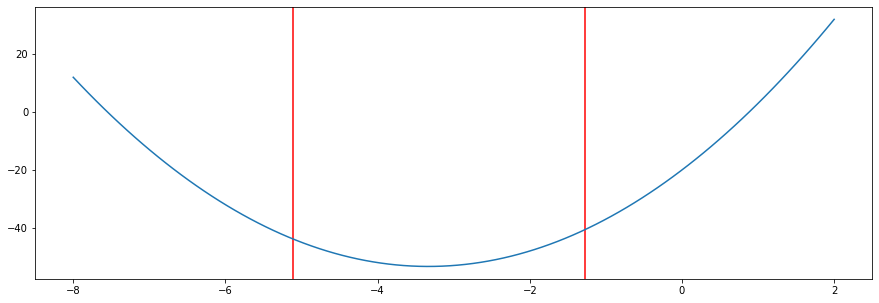

In [20]:
X = np.linspace(-8, 2, 100)
Y = example_f(X)

plt.figure(figsize=(15, 5))
plt.axvline(x=a, color='red')
plt.axvline(x=b, color='red')
plt.plot(X, Y)

# Problem 2.5 (4 pts)

In this problem we consider [unimodal function](https://www.wikiwand.com/en/Unimodality#/Unimodal_function)
and will play with _golden section search_ method.

First you should implement the _Fibonacci search_ algorithm provided that you have the (global) array of Fibonacci numbers. Next you should implement the _golden section search_ which uses only _golden ratio_ $\varphi = (1+\sqrt 5)/2$.

* Implement the [Fibonacci search algorithm](https://www.wikiwand.com/en/Golden-section_search#/Fibonacci_search)<br/>`(a, b) = fibonacci_search(f, a, b, n; ε=1e-4)`<br/>to be run on univariate function $f$, with bracketing interval $[a, b]$, for $n > 1$ function evaluations. It should return the new interval $(a, b)$. The optional parameter $\varepsilon$ should control the lowest-level interval length.
* Implement [Golden section search](https://www.wikiwand.com/en/Golden-section_search#)<br/>`(a, b) = gs_search(f, a, b, n)`<br/> to be run on a univariate function $f$ , with bracketing interval $[a, b]$ , for $n > 1$ function evaluations. It returns the new interval $(a, b)$. Guaranteeing convergence to within $\varepsilon$ requires $n = (b-a)/(\varepsilon \ln\varphi)$.

Present the results on various kind of functions.

References:
- [Fibonacci Search in Optimization of Unimodal Functions](https://www.maplesoft.com/applications/view.aspx?SID=4193&view=html)
- [Golden section search](https://www.wikiwand.com/en/Golden-section_search#)

## Fibonacci search 

In [21]:
%%time
fib_arr = [0, 1]
for i in range(2, 10000):
    fib_arr.append(fib_arr[i - 1] + fib_arr[i - 2])

CPU times: user 8.81 ms, sys: 7.69 ms, total: 16.5 ms
Wall time: 3.27 ms


Note: Actually the global fibonacci array is not needed as we can generate fib numbers on the fly

In [22]:
 def fibonacci_search(
    f: Callable[[float], float], 
    a: float, 
    b: float, 
    N: Optional[int],
    eps: float = 1e-4
):        
    if N >= len(fib_arr):
        raise RuntimeError(f'N = {N} >= len(fib_arr) = {len(fib_arr)}')
    
    get_h: Callable[[], float] = lambda: b - a
    
    fib1, fib2 = 1, 2
    
    for i in range(N):
        phi = fib2 / fib1
        fib1, fib2 = fib2, fib2 + fib1
    
        a_phi2 = a + (1 / phi ** 2) * get_h()
        a_phi = a + (1 / phi) * get_h()
        
        if f(a_phi2) < f(a_phi):
            b = a_phi
        else:
            a = a_phi2
            
        if get_h() < eps:
            print(f'Breaking early after {i + 1} iters. h = {get_h()} < eps = {eps}')
            return a, b
            
    return a, b

### Test on function from the previous task

a = -5.109999999999999 b = -1.27


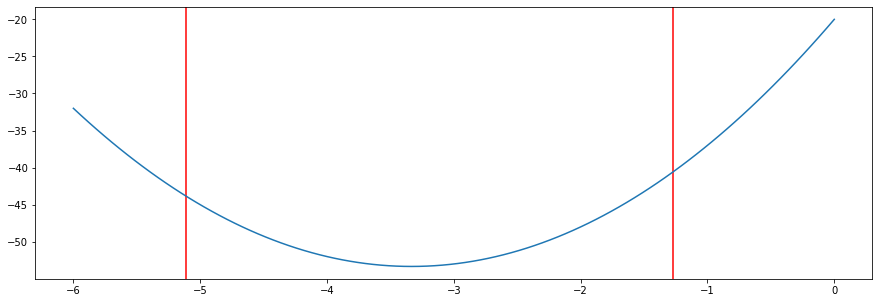

In [23]:
X = np.linspace(-6, 0, 100)
Y = example_f(X)

a, b = find_initial_bracket(example_f)

plt.figure(figsize=(15, 5))
plt.axvline(x=a, color='red')
plt.axvline(x=b, color='red')
plt.plot(X, Y)
print(f'a = {a} b = {b}')

In [24]:
for i in [2 ** i for i in range(8)]:
    new_a, new_b = fibonacci_search(
        f=example_f, 
        a=a, 
        b=b, 
        N=i,
    )
    print(f'i = {i}: gs_search: ({new_a}, {new_b})\n')

i = 1: gs_search: (-4.1499999999999995, -1.27)

i = 2: gs_search: (-4.1499999999999995, -2.23)

i = 4: gs_search: (-3.6999999999999997, -2.9979999999999998)

i = 8: gs_search: (-3.370424920534011, -3.2673891402714927)

i = 16: gs_search: (-3.3346196430026214, -3.3324267386600033)

Breaking early after 23 iters. h = 7.552769634244783e-05 < eps = 0.0001
i = 32: gs_search: (-3.3333865600013746, -3.333311032305032)

Breaking early after 23 iters. h = 7.552769634244783e-05 < eps = 0.0001
i = 64: gs_search: (-3.3333865600013746, -3.333311032305032)

Breaking early after 23 iters. h = 7.552769634244783e-05 < eps = 0.0001
i = 128: gs_search: (-3.3333865600013746, -3.333311032305032)



### Test on $f(x) = 21x^2 + 37x - 42$

#### Minimum: $f(-0.881) = -58.298$

Starting fibonacci_search for a = -1.27 b = -0.31000000000000005
Breaking early after 20 iters. h = 7.93798390101852e-05 < eps = 0.0001


(-0.8810147375295113, -0.8809353576905011)

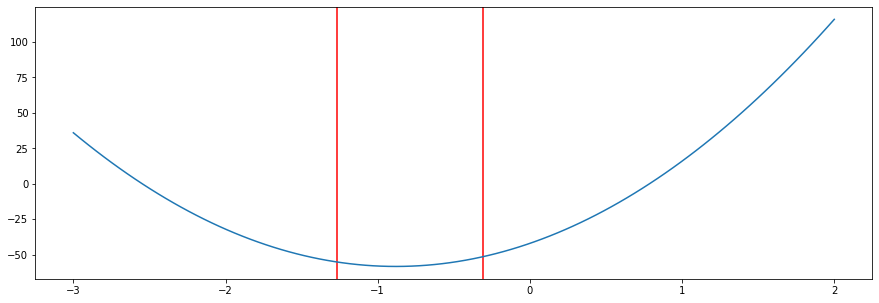

In [25]:
l, r = -3, 2

f = lambda x: 21 * x ** 2 + 37 * x - 42
X = np.linspace(l, r, 100)
Y = f(X)

a, b = find_initial_bracket(f)

plt.figure(figsize=(15, 5))
plt.axvline(x=a, color='red')
plt.axvline(x=b, color='red')
plt.plot(X, Y)

print(f'Starting fibonacci_search for a = {a} b = {b}')
fibonacci_search(
    f=f, 
    a=a, 
    b=b, 
    N=100,
)

### Test on $f(x) = x^{2} - 420x + 69$
#### Minimum: f$(210) = -44031$

Starting fibonacci_search for a = 81.92 b = 327.68
Breaking early after 32 iters. h = 6.880715272927773e-05 < eps = 0.0001


(209.99998272201432, 210.00005152916705)

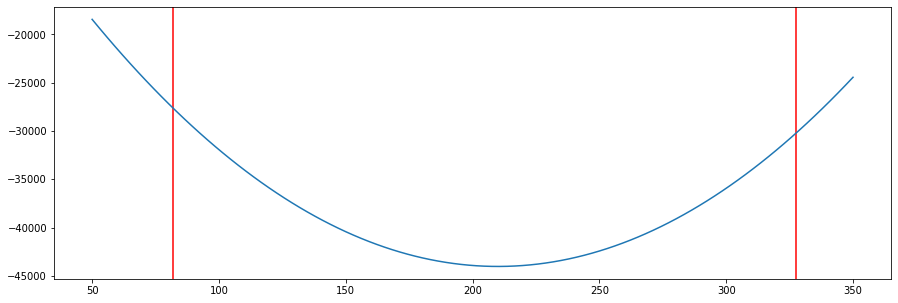

In [26]:
l, r = 50, 350

f = lambda x: x ** 2 - 420 * x + 69
X = np.linspace(l, r, 100)
Y = f(X)

a, b = find_initial_bracket(f)

plt.figure(figsize=(15, 5))
plt.axvline(x=a, color='red')
plt.axvline(x=b, color='red')
plt.plot(X, Y)

print(f'Starting fibonacci_search for a = {a} b = {b}')
fibonacci_search(
    f=f, 
    a=a, 
    b=b, 
    N=100,
)

## Golden section search

In [27]:
def gs_search(
    f: Callable[[float], float], 
    a: float, 
    b: float, 
    N: Optional[int],
    eps: float = 1e-4
):        
    invphi: float = (np.sqrt(5) - 1) / 2  # 1 / phi
    invphi2: float = (3 - np.sqrt(5)) / 2  # 1 / phi^2
    
    get_h: Callable[[], float] = lambda: b - a
    
    if N is None:
        N = int(np.ceil(np.log(eps / get_h()) / np.log(invphi)))
    
    for i in range(N):
        a_phi2 = a + invphi2 * get_h()
        a_phi = a + invphi * get_h()
        
        if f(a_phi2) < f(a_phi):
            b = a_phi
        else:
            a = a_phi2
            
    return a, b

### Test on function from the previous task

a = -5.109999999999999 b = -1.27


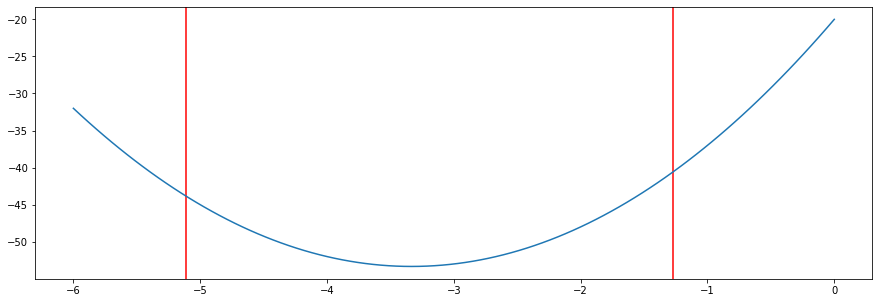

In [28]:
X = np.linspace(-6, 0, 100)
Y = example_f(X)

a, b = find_initial_bracket(example_f)

plt.figure(figsize=(15, 5))
plt.axvline(x=a, color='red')
plt.axvline(x=b, color='red')
plt.plot(X, Y)
print(f'a = {a} b = {b}')

In [29]:
for i in [2 ** i for i in range(8)]:
    new_a, new_b = gs_search(
        f=example_f, 
        a=a, 
        b=b, 
        N=i,
    )
    print(f'i = {i}: gs_search: ({new_a}, {new_b})')

i = 1: gs_search: (-5.109999999999999, -2.7367494832004033)
i = 2: gs_search: (-4.203498966400807, -2.7367494832004033)
i = 4: gs_search: (-3.643250516799596, -3.0830020671983847)
i = 8: gs_search: (-3.3787370800100947, -3.296997932801615)
i = 16: gs_search: (-3.3345145941745833, -3.33277467537605)
i = 32: gs_search: (-3.333336110977468, -3.333335322613555)
i = 64: gs_search: (-3.3333355797939235, -3.3333355797937614)
i = 128: gs_search: (-3.333335579793779, -3.3333355797937787)


### Test on $f(x) = 21x^2 + 37x - 42$

#### Minimum: $f(-0.881) = -58.298$

Starting gs_search for a = -1.27 b = -0.31000000000000005


(-0.8809523771767934, -0.8809523771767933)

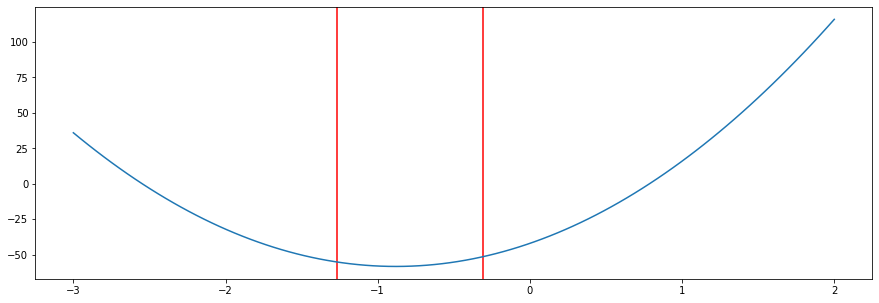

In [30]:
l, r = -3, 2

f = lambda x: 21 * x ** 2 + 37 * x - 42
X = np.linspace(l, r, 100)
Y = f(X)

a, b = find_initial_bracket(f)

plt.figure(figsize=(15, 5))
plt.axvline(x=a, color='red')
plt.axvline(x=b, color='red')
plt.plot(X, Y)

print(f'Starting gs_search for a = {a} b = {b}')
gs_search(
    f=f, 
    a=a, 
    b=b, 
    N=100,
)

### Test on $f(x) = x^{2} - 420x + 69$
#### Minimum: f$(210) = -44031$

Starting fibonacci_search for a = 81.92 b = 327.68


(209.9999999284801, 209.99999992848012)

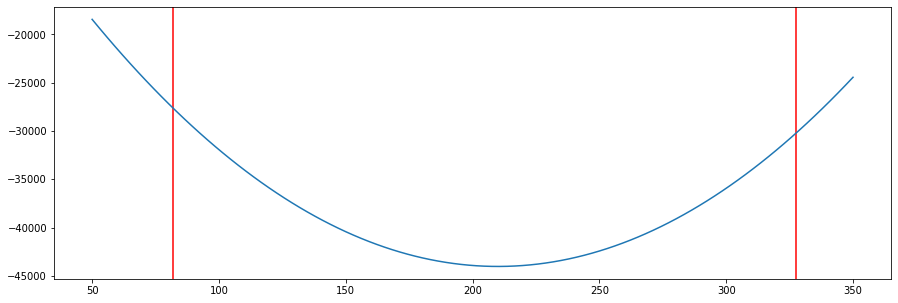

In [31]:
l, r = 50, 350

f = lambda x: x ** 2 - 420 * x + 69
X = np.linspace(l, r, 100)
Y = f(X)

a, b = find_initial_bracket(f)

plt.figure(figsize=(15, 5))
plt.axvline(x=a, color='red')
plt.axvline(x=b, color='red')
plt.plot(X, Y)

print(f'Starting fibonacci_search for a = {a} b = {b}')
gs_search(
    f=f, 
    a=a, 
    b=b, 
    N=100,
)